In [2]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlens.ensemble import SuperLearner
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import seaborn as sns
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set(style="white")

# For reproducibility
np.random.seed(42)

In [6]:
X_train = np.load('X_train_PE_no_lab_measurement_UKSpain.npy')
y_train = np.load('y_train_PE_no_lab_measurement_UKSpain.npy')

In [7]:
# Load the test sets
X_test_UK = np.load('X_test_PE_no_lab_measurement_UK.npy')
y_test_UK = np.load('y_test_PE_no_lab_measurement_UK.npy')
X_test_Spain = np.load('X_test_PE_no_lab_measurement_Spain.npy')
y_test_Spain = np.load('y_test_PE_no_lab_measurement_Spain.npy')
X_test = np.load('X_test_PE_no_lab_measurement_UKSpain.npy')
y_test = np.load('y_test_PE_no_lab_measurement_UKSpain.npy')

In [8]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [9]:
unique, counts = np.unique(X_train[:,-1], return_counts=True)
dict(zip(unique, counts))

{0: 205688, 1: 9810}

In [10]:
205688/9810

20.96717635066259

# XGBoost

In [38]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate (eta)
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]
tree_method = ['hist']
# Gamma for overfitting control
min_split_loss = [0, 0.5]
# Balance weights for imbalanced classes for AUC
scale_pos_weight = [57.527]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step,
             'tree_method': tree_method,
             'min_split_loss': min_split_loss,
            'scale_pos_weight': scale_pos_weight}

In [39]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [40]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:49:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:50:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:50:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:51:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:52:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:52:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:52:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:53:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:54:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:54:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:54:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                      verbosity=None),
              refit=False, scoring='roc_auc',
              search_spaces={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
   

In [41]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 0), ('max_depth', 3), ('min_split_loss', 0.5), ('n_estimators', 150), ('scale_pos_weight', 57.527), ('tree_method', 'hist')])
Best AUROC: 0.7381911779167301


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 0), ('max_depth', 3), ('min_split_loss', 0.5), ('n_estimators', 150), ('scale_pos_weight', 57.527), ('tree_method', 'hist')])

In [5]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 3, n_estimators = 150,learning_rate = 0.1, max_delta_step = 0, min_split_loss = 0.5, scale_pos_weight = 57.527, use_label_encoder=False)

In [6]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[09:05:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, min_split_loss=0.5, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=57.527, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [44]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, XGBOOSTmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, XGBOOSTmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7375177344997599
Accuracy is: 0.6557215777262181
Average Precision is: 0.04817656929555713
Weighted F1 is: 0.7766933950839787
Sensitivity is: 0.6869565217391305
#################################################
Results for UK
AUROC is: 0.7162044286255598
Accuracy is: 0.6611846635059903
Average Precision is: 0.03635935623293131
Weighted F1 is: 0.7818292536429725
Sensitivity is: 0.6472049689440994
#################################################
Results for Spain
AUROC is: 0.7919698162534721
Accuracy is: 0.5644312952005259
Average Precision is: 0.09610866445059471
Weighted F1 is: 0.6866181661484636
Sensitivity is: 0.9652173913043478


In [7]:
# Evaluate only on specific subpopulations
y_test_men = y_test[np.where(X_test[:,1] == 1)[0]]
X_test_men = X_test[np.where(X_test[:,1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Men)')
print('AUROC is:', metrics.roc_auc_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('Average Precision is:', metrics.average_precision_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_men, XGBOOSTmodel.predict(X_test_men), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('#################################################')
y_test_women = y_test[np.where(X_test[:,1] == 0)[0]]
X_test_women = X_test[np.where(X_test[:,1] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Women)')
print('AUROC is:', metrics.roc_auc_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('Average Precision is:', metrics.average_precision_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_women, XGBOOSTmodel.predict(X_test_women), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('#################################################')
y_test_20 = y_test[np.where(X_test[:,0] == 0)[0]]
X_test_20 = X_test[np.where(X_test[:,0] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (0-20)')
print('AUROC is:', metrics.roc_auc_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('Average Precision is:', metrics.average_precision_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_20, XGBOOSTmodel.predict(X_test_20), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('#################################################')
y_test_40 = y_test[np.where(X_test[:,0] == 1)[0]]
X_test_40 = X_test[np.where(X_test[:,0] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (20-40)')
print('AUROC is:', metrics.roc_auc_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('Average Precision is:', metrics.average_precision_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_40, XGBOOSTmodel.predict(X_test_40), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('#################################################')
y_test_60 = y_test[np.where(X_test[:,0] == 2)[0]]
X_test_60 = X_test[np.where(X_test[:,0] == 2)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (40-60)')
print('AUROC is:', metrics.roc_auc_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('Average Precision is:', metrics.average_precision_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_60, XGBOOSTmodel.predict(X_test_60), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('#################################################')
y_test_80 = y_test[np.where(X_test[:,0] == 3)[0]]
X_test_80 = X_test[np.where(X_test[:,0] == 3)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (60-80)')
print('AUROC is:', metrics.roc_auc_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('Average Precision is:', metrics.average_precision_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_80, XGBOOSTmodel.predict(X_test_80), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('#################################################')
y_test_120 = y_test[np.where(X_test[:,0] == 4)[0]]
X_test_120 = X_test[np.where(X_test[:,0] == 4)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (>80)')
print('AUROC is:', metrics.roc_auc_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('Average Precision is:', metrics.average_precision_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_120, XGBOOSTmodel.predict(X_test_120), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('#################################################')

Results for UK+Spain (Men)
AUROC is: 0.7412153359029773
Accuracy is: 0.5895783152966719
Average Precision is: 0.05504237823796229
Weighted F1 is: 0.7233315595669108
Sensitivity is: 0.7681895093062606
#################################################
Results for UK+Spain (Women)
AUROC is: 0.7157166939375537
Accuracy is: 0.7356340683662596
Average Precision is: 0.03458117621370888
Weighted F1 is: 0.8356839878448036
Sensitivity is: 0.541033434650456
#################################################
Results for UK+Spain (0-20)
AUROC is: 0.9519945909398243
Accuracy is: 0.9905405405405405
Average Precision is: 0.013888888888888888
Weighted F1 is: 0.9945753288930477
Sensitivity is: 0.0
#################################################
Results for UK+Spain (20-40)
AUROC is: 0.8047595499192601
Accuracy is: 0.6912408759124088
Average Precision is: 0.09448137561153946
Weighted F1 is: 0.8042215374982123
Sensitivity is: 0.7721518987341772
#################################################
Results fo

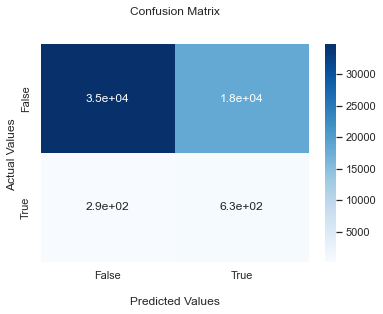

In [45]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

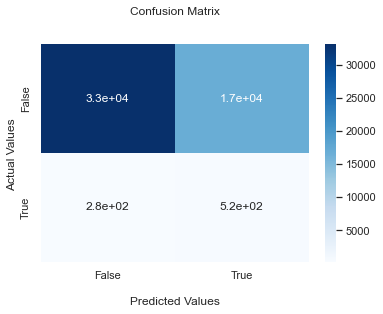

In [46]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, XGBOOSTmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

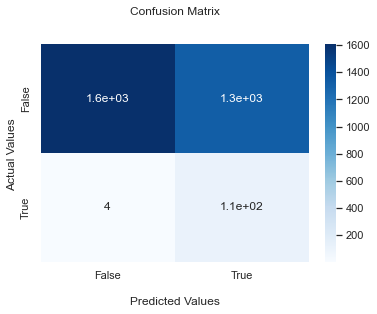

In [47]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [48]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.518, AUROC-Score=0.69579


In [49]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.518).astype(int)
y_pred_UK = (XGBOOSTmodel.predict_proba(X_test_UK)[:,1] >= 0.518).astype(int)
y_pred_Spain = (XGBOOSTmodel.predict_proba(X_test_Spain)[:,1] >= 0.518).astype(int)

In [50]:
# Test results with thresholding and no undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6731442405980468
Accuracy is: 0.6787006960556845
Average Precision is: 0.028938882433145203
Weighted F1 is: 0.7933358357097358
Sensitivity is: 0.6673913043478261
#################################################
Results for UK
AUROC is: 0.655490242234535
Accuracy is: 0.6851651486239254
Average Precision is: 0.025336079300271087
Weighted F1 is: 0.7990467564934719
Sensitivity is: 0.6248447204968944
#################################################
Results for Spain
AUROC is: 0.7601966696870219
Accuracy is: 0.5706771860618014
Average Precision is: 0.07713879589558603
Weighted F1 is: 0.6918701662801314
Sensitivity is: 0.9652173913043478


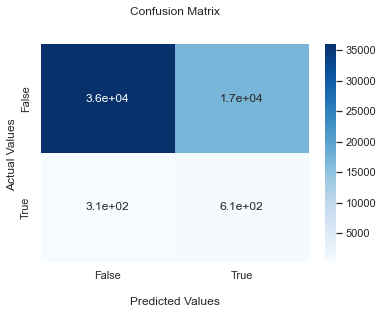

In [51]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

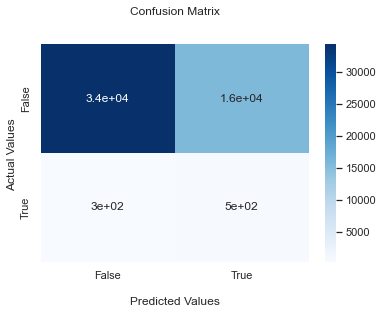

In [52]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

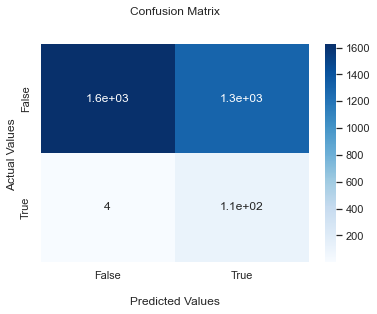

In [53]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [97]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [98]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [99]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', XGBOOSTmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', XGBOOSTmodel)
    ])

In [57]:
# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate (eta)
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]
tree_method = ['hist']
# Gamma for overfitting control
min_split_loss = [0, 0.5]
# Balance weights for imbalanced classes for AUC
scale_pos_weight = [4]

# Create the grid
param_grid = {'classification__max_depth': max_depth,
               'classification__n_estimators': n_estimators,
               'classification__learning_rate': lr,
               'classification__max_delta_step': max_delta_step,
             'classification__tree_method': tree_method,
             'classification__min_split_loss': min_split_loss,
             'classification__scale_pos_weight': scale_pos_weight}

In [58]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:04:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:04:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:04:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:04:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:04:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:05:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:05:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:05:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       enable_categorical=False,
                                                       gamma=None, gpu_id=None,
                                                       im...
              search_spaces={'classification__lear

In [60]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__learning_rate', 0.3), ('classification__max_delta_step', 0), ('classification__max_depth', 2), ('classification__min_split_loss', 0.06220097640444155), ('classification__n_estimators', 200), ('classification__scale_pos_weight', 4), ('classification__tree_method', 'hist')])
Best AUROC: 0.7383888443414361


Best parameter combo: OrderedDict([('classification__learning_rate', 0.3), ('classification__max_delta_step', 0), ('classification__max_depth', 2), ('classification__min_split_loss', 0.06220097640444155), ('classification__n_estimators', 200), ('classification__scale_pos_weight', 4), ('classification__tree_method', 'hist')])

In [100]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 2, n_estimators = 200,learning_rate = 0.3, max_delta_step = 0, min_split_loss = 0.06220097640444155, scale_pos_weight = 4, use_label_encoder=False)

In [101]:
XGBOOSTmodel.fit(X_res, np.ravel(y_res))

[10:27:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.0622009747, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=2, min_child_weight=1,
              min_split_loss=0.06220097640444155, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [79]:
# Test results with undersampling and without thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, XGBOOSTmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, XGBOOSTmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, XGBOOSTmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, XGBOOSTmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, XGBOOSTmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.736750666070043
Accuracy is: 0.6609559164733179
Average Precision is: 0.04688212989232444
Weighted F1 is: 0.7805048652515946
Sensitivity is: 0.6902173913043478
#################################################
Results for UK
AUROC is: 0.7165941482707572
Accuracy is: 0.6676371648338678
Average Precision is: 0.0356214790825323
Weighted F1 is: 0.7864880584983722
Sensitivity is: 0.6509316770186335
#################################################
Results for Spain
AUROC is: 0.7927912538435258
Accuracy is: 0.5493096646942801
Average Precision is: 0.09518804953148528
Weighted F1 is: 0.6737277906517732
Sensitivity is: 0.9652173913043478


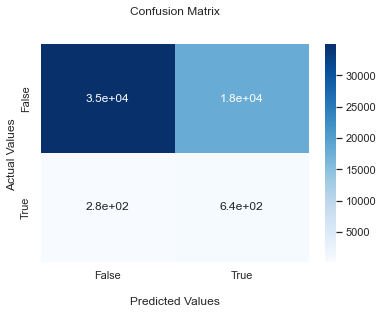

In [64]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

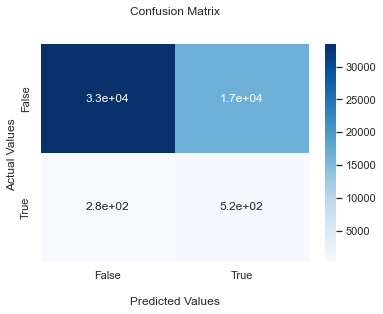

In [65]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, XGBOOSTmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

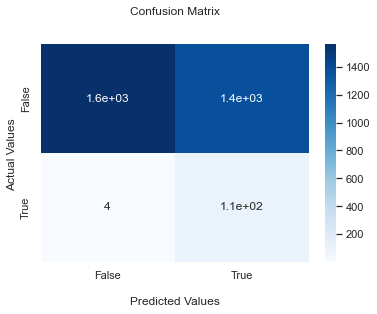

In [66]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, XGBOOSTmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [69]:
# Feature importance (UK/Spain)
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


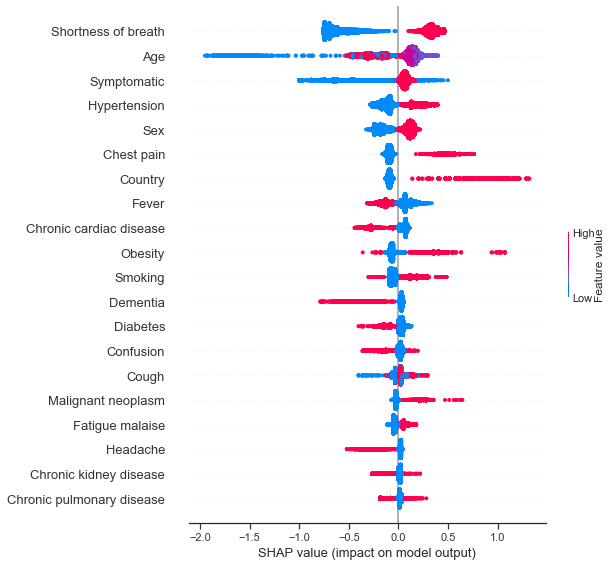

In [80]:
features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing']
f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)
f.savefig("PE_Shap.png", bbox_inches='tight', dpi=600)

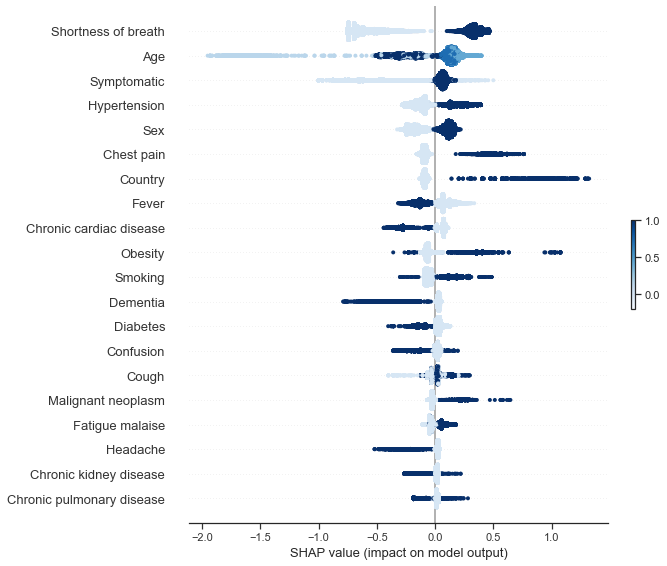

In [92]:
features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap.png", bbox_inches='tight', dpi=600)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


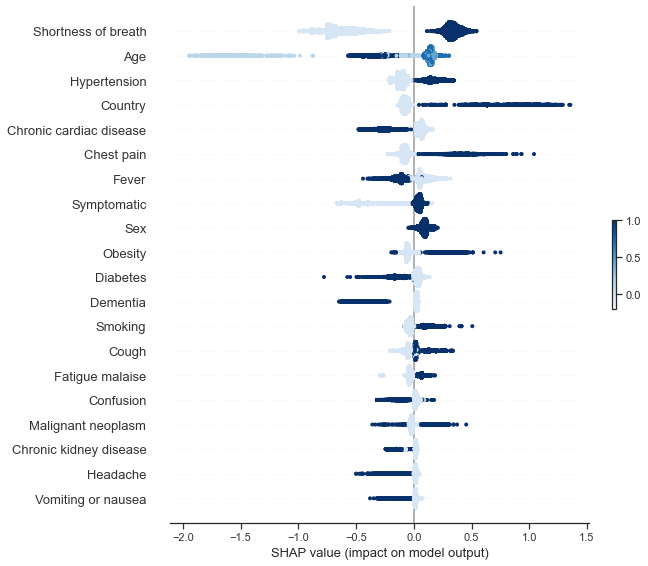

In [8]:
# Feature importance (UK/Spain) for Men
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_men)

features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_men, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap_Men.png", bbox_inches='tight', dpi=600)

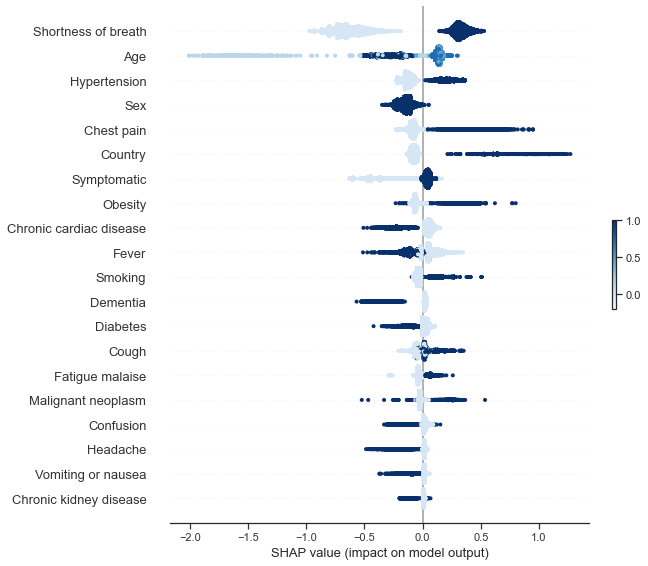

In [9]:
# Feature importance (UK/Spain) for Women
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_women)

features = ['Age', 'Sex', 'Country', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_women, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("PE_Shap_Women.png", bbox_inches='tight', dpi=600)

In [77]:
features

['Age',
 'Sex',
 'Country',
 'AIDS',
 'Asthma',
 'Chronic cardiac disease',
 'Chronic haematological disease',
 'Chronic kidney disease',
 'Chronic neurological disorder',
 'Chronic pulmonary disease',
 'Dementia',
 'Diabetes',
 'Hypertension',
 'Liver disease',
 'Malignant neoplasm',
 'Malnutrition',
 'Obesity',
 'Rheumatologic disorder',
 'Smoking',
 'Symptomatic',
 'Abdominal pain',
 'Confusion',
 'Bleeding',
 'Chest pain',
 'Conjunctivitis',
 'Cough',
 'Diarrhoea',
 'Ear pain',
 'Fatigue malaise',
 'Headache',
 'Fever',
 'Lost or altered sense of smell',
 'Lost or altered sense of taste',
 'Lymphadenopathy',
 'Muscle aches or joint pain',
 'Runny nose',
 'Seizures',
 'Severe dehydration',
 'Shortness of breath',
 'Skin rash',
 'Sore throat',
 'Vomiting or nausea',
 'Wheezing']

In [104]:
X_test_df = pd.DataFrame(data=X_test,
    columns=features)

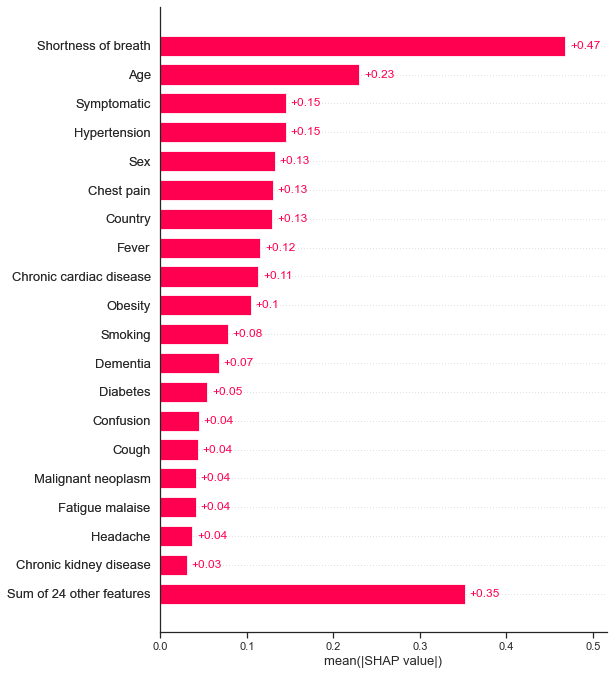

In [138]:
# Define colormap
my_cmap = plt.get_cmap('tab20c')

f = plt.figure()
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20, show=False)
            
f.savefig("PE_Shap_Bar.png", bbox_inches='tight', dpi=600)

In [122]:
Sex = ["Women" if shap_values[i,"Sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(Sex).abs.mean(0))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [123]:
np.unique(Sex, return_counts=True)

(array(['Men', 'Women'], dtype='<U5'), array([29477, 24398]))

In [127]:
shap.plots.bar(shap_values.cohorts(3).abs.mean(0))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 0 Axes>

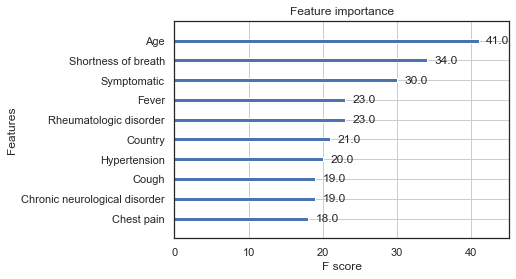

In [21]:
XGBOOSTmodel.get_booster().feature_names = features
f = plt.figure()
plot_importance(XGBOOSTmodel.get_booster(), max_num_features=10)
plt.savefig('PE_FI.png', dpi=600, bbox_inches='tight')

In [93]:
# Time for prediction
start = time.time()
XGBOOSTmodel.predict(X_test)
end = time.time()
end - start

0.031358957290649414

In [67]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_res)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.470, AUROC-Score=0.69768


In [68]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.470).astype(int)
y_pred_UK = (XGBOOSTmodel.predict_proba(X_test_UK)[:,1] >= 0.470).astype(int)
y_pred_Spain = (XGBOOSTmodel.predict_proba(X_test_Spain)[:,1] >= 0.470).astype(int)

In [69]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6734054857898216
Accuracy is: 0.6235730858468678
Average Precision is: 0.028063940095395125
Weighted F1 is: 0.7525562941528656
Sensitivity is: 0.725
#################################################
Results for UK
AUROC is: 0.6589959684688376
Accuracy is: 0.6283123168020774
Average Precision is: 0.02489838630670374
Weighted F1 is: 0.7573341455204834
Sensitivity is: 0.6906832298136646
#################################################
Results for Spain
AUROC is: 0.7465308001960755
Accuracy is: 0.5443786982248521
Average Precision is: 0.07307589588198986
Weighted F1 is: 0.6694697566469096
Sensitivity is: 0.9652173913043478


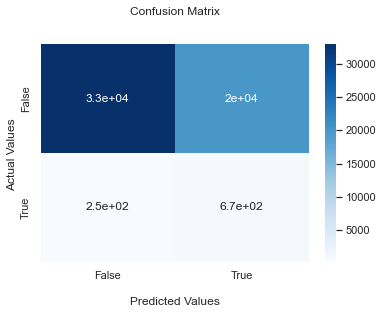

In [70]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

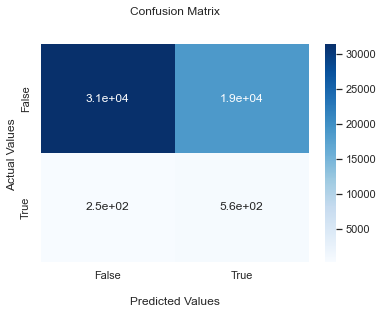

In [71]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

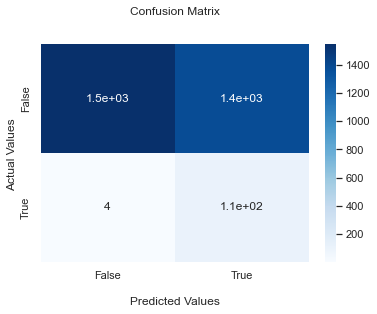

In [72]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Logistic Regression

In [59]:
# In this case we are tuning for Logistic Regression hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'C': classifier__C,
               'penalty': classifier__penalty}

In [69]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([211816,   3682]))

In [60]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [61]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LOGmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           solver='liblinear'),
              refit=False, scoring='roc_auc',
              search_spaces={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                             'penalty': ['l1', 'l2']},
              verbose=1)

In [62]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('C', 0.1), ('penalty', 'l1')])
Best AUROC: 0.7247182602665749


Best parameter combo: OrderedDict([('C', 0.1), ('penalty', 'l1')])

In [33]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [34]:
LOGmodel.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [65]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LOGmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LOGmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, LOGmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, LOGmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, LOGmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, LOGmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, LOGmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, LOGmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, LOGmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, LOGmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, LOGmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, LOGmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7104210096349239
Accuracy is: 0.6397958236658933
Average Precision is: 0.0409560058760403
Weighted F1 is: 0.7648998095802642
Sensitivity is: 0.6934782608695652
#################################################
Results for UK
AUROC is: 0.6939966537993383
Accuracy is: 0.6490468789959278
Average Precision is: 0.033127341429660076
Weighted F1 is: 0.7729286258914445
Sensitivity is: 0.6546583850931676
#################################################
Results for Spain
AUROC is: 0.7451909508177241
Accuracy is: 0.48520710059171596
Average Precision is: 0.07943648774888837
Weighted F1 is: 0.6161451149543229
Sensitivity is: 0.9652173913043478


In [35]:
# Evaluate only on specific subpopulations
y_test_men = y_test[np.where(X_test[:,1] == 1)[0]]
X_test_men = X_test[np.where(X_test[:,1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Men)')
print('AUROC is:', metrics.roc_auc_score(y_test_men, LOGmodel.predict_proba(X_test_men)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_men, LOGmodel.predict(X_test_men)))
print('Average Precision is:', metrics.average_precision_score(y_test_men, LOGmodel.predict_proba(X_test_men)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_men, LOGmodel.predict(X_test_men), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_men, LOGmodel.predict(X_test_men)))
print('#################################################')
y_test_women = y_test[np.where(X_test[:,1] == 0)[0]]
X_test_women = X_test[np.where(X_test[:,1] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Women)')
print('AUROC is:', metrics.roc_auc_score(y_test_women, LOGmodel.predict_proba(X_test_women)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_women, LOGmodel.predict(X_test_women)))
print('Average Precision is:', metrics.average_precision_score(y_test_women, LOGmodel.predict_proba(X_test_women)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_women, LOGmodel.predict(X_test_women), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_women, LOGmodel.predict(X_test_women)))
print('#################################################')
y_test_20 = y_test[np.where(X_test[:,0] == 0)[0]]
X_test_20 = X_test[np.where(X_test[:,0] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (0-20)')
print('AUROC is:', metrics.roc_auc_score(y_test_20, LOGmodel.predict_proba(X_test_20)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_20, LOGmodel.predict(X_test_20)))
print('Average Precision is:', metrics.average_precision_score(y_test_20, LOGmodel.predict_proba(X_test_20)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_20, LOGmodel.predict(X_test_20), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_20, LOGmodel.predict(X_test_20)))
print('#################################################')
y_test_40 = y_test[np.where(X_test[:,0] == 1)[0]]
X_test_40 = X_test[np.where(X_test[:,0] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (20-40)')
print('AUROC is:', metrics.roc_auc_score(y_test_40, LOGmodel.predict_proba(X_test_40)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_40, LOGmodel.predict(X_test_40)))
print('Average Precision is:', metrics.average_precision_score(y_test_40, LOGmodel.predict_proba(X_test_40)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_40, LOGmodel.predict(X_test_40), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_40, LOGmodel.predict(X_test_40)))
print('#################################################')
y_test_60 = y_test[np.where(X_test[:,0] == 2)[0]]
X_test_60 = X_test[np.where(X_test[:,0] == 2)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (40-60)')
print('AUROC is:', metrics.roc_auc_score(y_test_60, LOGmodel.predict_proba(X_test_60)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_60, LOGmodel.predict(X_test_60)))
print('Average Precision is:', metrics.average_precision_score(y_test_60, LOGmodel.predict_proba(X_test_60)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_60, LOGmodel.predict(X_test_60), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_60, LOGmodel.predict(X_test_60)))
print('#################################################')
y_test_80 = y_test[np.where(X_test[:,0] == 3)[0]]
X_test_80 = X_test[np.where(X_test[:,0] == 3)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (60-80)')
print('AUROC is:', metrics.roc_auc_score(y_test_80, LOGmodel.predict_proba(X_test_80)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_80, LOGmodel.predict(X_test_80)))
print('Average Precision is:', metrics.average_precision_score(y_test_80, LOGmodel.predict_proba(X_test_80)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_80, LOGmodel.predict(X_test_80), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_80, LOGmodel.predict(X_test_80)))
print('#################################################')
y_test_120 = y_test[np.where(X_test[:,0] == 4)[0]]
X_test_120 = X_test[np.where(X_test[:,0] == 4)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (>80)')
print('AUROC is:', metrics.roc_auc_score(y_test_120, LOGmodel.predict_proba(X_test_120)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_120, LOGmodel.predict(X_test_120)))
print('Average Precision is:', metrics.average_precision_score(y_test_120, LOGmodel.predict_proba(X_test_120)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_120, LOGmodel.predict(X_test_120), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_120, LOGmodel.predict(X_test_120)))
print('#################################################')

Results for UK+Spain (Men)
AUROC is: 0.7111546668138113
Accuracy is: 0.5593852834413271
Average Precision is: 0.04746146494148928
Weighted F1 is: 0.6987399204143502
Sensitivity is: 0.7766497461928934
#################################################
Results for UK+Spain (Women)
AUROC is: 0.6926882957192095
Accuracy is: 0.736945651282892
Average Precision is: 0.029192766891631382
Weighted F1 is: 0.8365505526955205
Sensitivity is: 0.5440729483282675
#################################################
Results for UK+Spain (0-20)
AUROC is: 0.9743069641649763
Accuracy is: 0.9054054054054054
Average Precision is: 0.02564102564102564
Weighted F1 is: 0.9496867843162788
Sensitivity is: 1.0
#################################################
Results for UK+Spain (20-40)
AUROC is: 0.7902849683251343
Accuracy is: 0.6578467153284672
Average Precision is: 0.052912451627302126
Weighted F1 is: 0.7801894689847075
Sensitivity is: 0.810126582278481
#################################################
Results fo

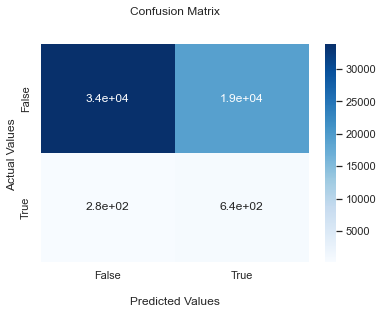

In [66]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, LOGmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

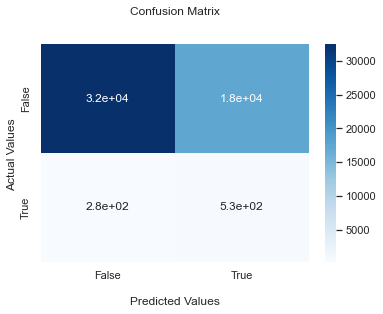

In [67]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, LOGmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

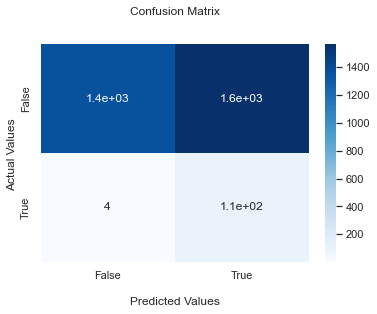

In [68]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, LOGmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [70]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LOGmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.493, AUROC-Score=0.67682


In [71]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (LOGmodel.predict_proba(X_test)[:,1] >= 0.493).astype(int)
y_pred_UK = (LOGmodel.predict_proba(X_test_UK)[:,1] >= 0.493).astype(int)
y_pred_Spain = (LOGmodel.predict_proba(X_test_Spain)[:,1] >= 0.493).astype(int)

In [72]:
# Test results with thresholding and no undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6669747796529457
Accuracy is: 0.6298283062645011
Average Precision is: 0.027559918523078344
Weighted F1 is: 0.7573727018827224
Sensitivity is: 0.7054347826086956
#################################################
Results for UK
AUROC is: 0.6533027715659354
Accuracy is: 0.6387582869395865
Average Precision is: 0.024548284162802806
Weighted F1 is: 0.7652561434929902
Sensitivity is: 0.6683229813664596
#################################################
Results for Spain
AUROC is: 0.7133910666805305
Accuracy is: 0.4806048652202498
Average Precision is: 0.0648235968487429
Weighted F1 is: 0.6118159888204573
Sensitivity is: 0.9652173913043478


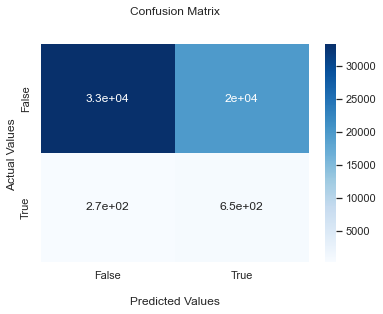

In [73]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

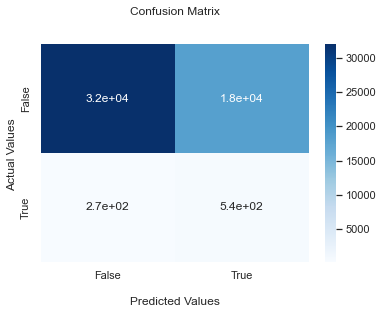

In [74]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

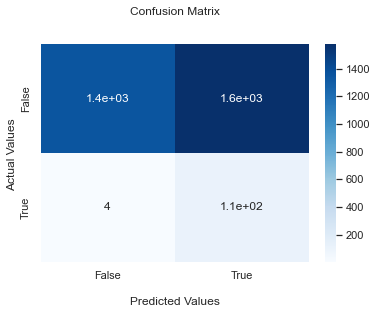

In [75]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [76]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [77]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [78]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', LOGmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', LOGmodel)
    ])

In [79]:
# In this case we are tuning for Logistic Regression hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'classification__C': classifier__C,
               'classification__penalty': classifier__penalty}

In [80]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         LogisticRegression(class_weight='balanced',
                                                            solver='liblinear'))]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                             'classification__penalty': ['l1', 'l2']},
              verbose=1)

In [81]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__C', 1.0), ('classification__penalty', 'l1')])
Best AUROC: 0.7235704280764327


Best parameter combo: OrderedDict([('classification__C', 1.0), ('classification__penalty', 'l1')])

In [82]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [83]:
LOGmodel.fit(X_res, np.ravel(y_res))

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [84]:
# Test results with undersampling and without thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LOGmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LOGmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, LOGmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, LOGmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, LOGmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, LOGmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, LOGmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, LOGmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, LOGmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, LOGmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, LOGmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, LOGmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.709703706592554
Accuracy is: 0.6393132250580046
Average Precision is: 0.04114698406510167
Weighted F1 is: 0.7645464293379346
Sensitivity is: 0.691304347826087
#################################################
Results for UK
AUROC is: 0.6931629467622356
Accuracy is: 0.6479255601676076
Average Precision is: 0.032970199793828425
Weighted F1 is: 0.7721087345875404
Sensitivity is: 0.6521739130434783
#################################################
Results for Spain
AUROC is: 0.7459767383134535
Accuracy is: 0.49539776462853385
Average Precision is: 0.08392880777582681
Weighted F1 is: 0.6256342531535797
Sensitivity is: 0.9652173913043478


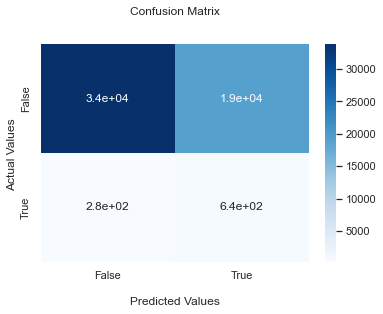

In [85]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, LOGmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

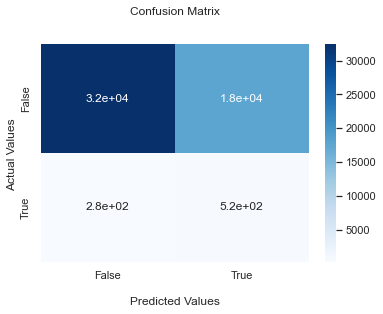

In [86]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, LOGmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

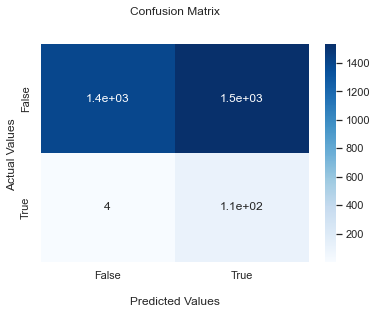

In [87]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, LOGmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [88]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LOGmodel.predict_proba(X_res)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.506, AUROC-Score=0.68129


In [89]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (LOGmodel.predict_proba(X_test)[:,1] >= 0.506).astype(int)
y_pred_UK = (LOGmodel.predict_proba(X_test_UK)[:,1] >= 0.506).astype(int)
y_pred_Spain = (LOGmodel.predict_proba(X_test_Spain)[:,1] >= 0.506).astype(int)

In [90]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6631183469968349
Accuracy is: 0.6474431554524362
Average Precision is: 0.027447920772237823
Weighted F1 is: 0.7706250829001661
Sensitivity is: 0.6793478260869565
#################################################
Results for UK
AUROC is: 0.648231896969995
Accuracy is: 0.6564436488108119
Average Precision is: 0.024330770903320142
Weighted F1 is: 0.7783964873324597
Sensitivity is: 0.639751552795031
#################################################
Results for Spain
AUROC is: 0.7177552323940524
Accuracy is: 0.4970414201183432
Average Precision is: 0.06599680001846243
Weighted F1 is: 0.6272715180173205
Sensitivity is: 0.9565217391304348


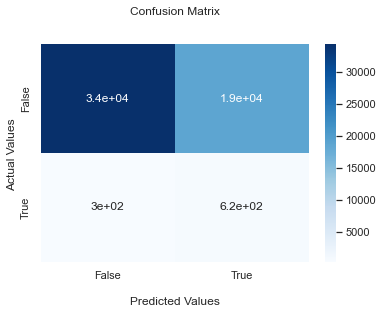

In [91]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

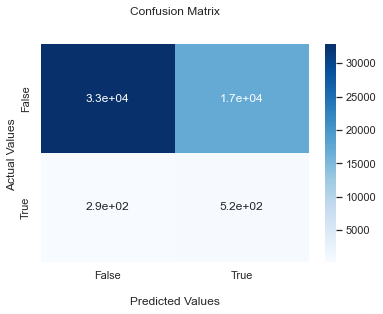

In [92]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

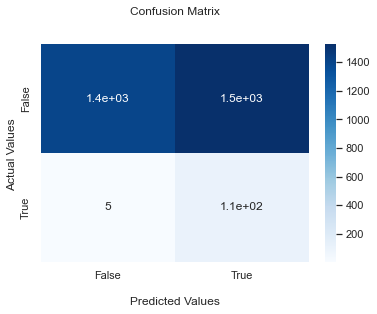

In [93]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Random Forest

In [5]:
# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# To account for class imbalance
class_weight=['balanced_subsample']

# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}

In [6]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [7]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(RFmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=RandomForestClassifier(), refit=False,
              scoring='roc_auc',
              search_spaces={'bootstrap': [True, False],
                             'class_weight': ['balanced_subsample'],
                             'max_depth': [10, 50, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [2, 4, 10],
                             'min_samples_split': [5, 10],
                             'n_estimators': [10, 25, 50, 100, 150]},
              verbose=1)

In [8]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 150)])
Best AUROC: 0.7363340190378747


Best parameter combo: OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 150)])

In [9]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', max_depth = 10, min_samples_split = 5, min_samples_leaf = 10, bootstrap = False, class_weight = 'balanced_subsample')

In [10]:
RFmodel.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=5, n_estimators=150)

In [11]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, RFmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, RFmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, RFmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, RFmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, RFmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, RFmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, RFmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, RFmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, RFmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, RFmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, RFmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, RFmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7346269391977602
Accuracy is: 0.6541252900232019
Average Precision is: 0.04746809483592027
Weighted F1 is: 0.7754952628875441
Sensitivity is: 0.6967391304347826
#################################################
Results for UK
AUROC is: 0.7119772306390408
Accuracy is: 0.6561288926484764
Average Precision is: 0.03690564394278664
Weighted F1 is: 0.7781127693121571
Sensitivity is: 0.6596273291925466
#################################################
Results for Spain
AUROC is: 0.797253457316439
Accuracy is: 0.6206443129520053
Average Precision is: 0.09089466031645801
Weighted F1 is: 0.7325007624492637
Sensitivity is: 0.9565217391304348


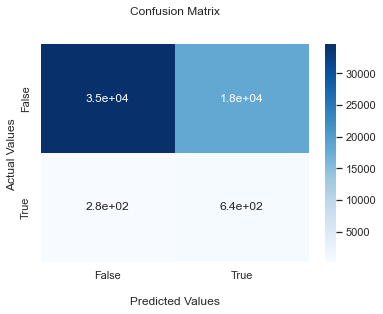

In [12]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, RFmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

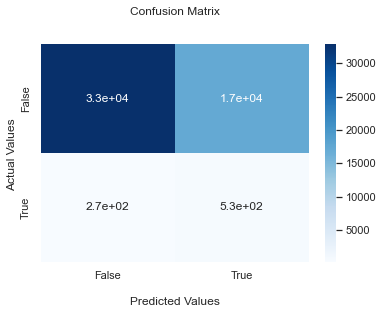

In [13]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, RFmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

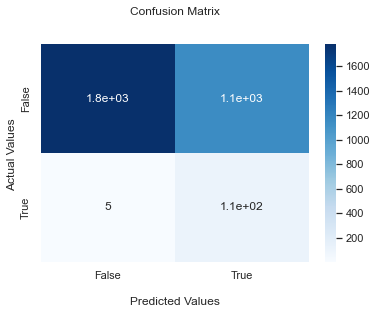

In [14]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, RFmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [15]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = RFmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.538, AUROC-Score=0.72565


In [17]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (RFmodel.predict_proba(X_test)[:,1] >= 0.538).astype(int)
y_pred_UK = (RFmodel.predict_proba(X_test_UK)[:,1] >= 0.538).astype(int)
y_pred_Spain = (RFmodel.predict_proba(X_test_Spain)[:,1] >= 0.538).astype(int)

In [18]:
# Test results with thresholding and no undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6656013309085237
Accuracy is: 0.7142645011600928
Average Precision is: 0.02888353276866421
Weighted F1 is: 0.818225355896853
Sensitivity is: 0.6152173913043478
#################################################
Results for UK
AUROC is: 0.6449901595479203
Accuracy is: 0.7186276631322173
Average Precision is: 0.024904281591001165
Weighted F1 is: 0.822283156366012
Sensitivity is: 0.568944099378882
#################################################
Results for Spain
AUROC is: 0.7843926857889811
Accuracy is: 0.6413543721236029
Average Precision is: 0.08739011681033185
Weighted F1 is: 0.748691481257012
Sensitivity is: 0.9391304347826087


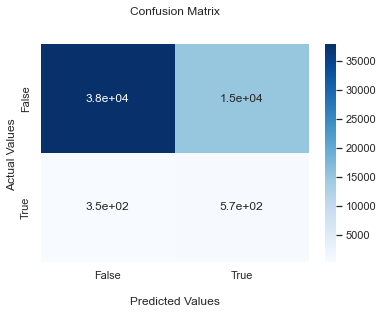

In [19]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

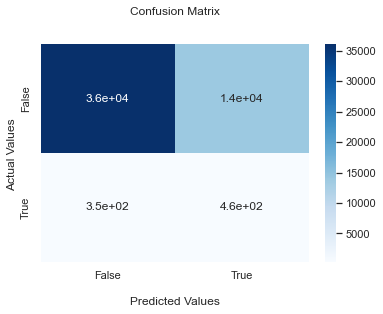

In [20]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

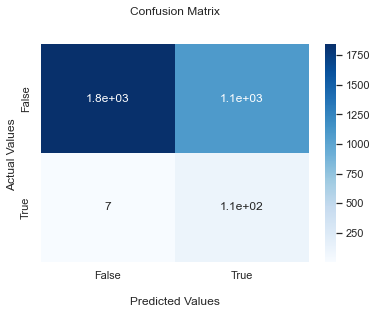

In [21]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [22]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [24]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [23]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', RFmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', RFmodel)
    ])

In [25]:
# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# To account for class imbalance
class_weight=['balanced_subsample']

# Create the grid
param_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap,
             'classification__class_weight': class_weight}

In [26]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         RandomForestClassifier(bootstrap=False,
                                                                class_weight='balanced_subsample',
                                                                max_depth=10,
                                                                max_features='sqrt',
                                                                min_samples_leaf=10,
                                                                min_samples_split=5,
                                                                n_estimators=1...
              refit=False, scoring='roc_auc',
       

In [27]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__class_weight', 'balanced_subsample'), ('classification__max_depth', None), ('classification__max_features', 'sqrt'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 10), ('classification__n_estimators', 150)])
Best AUROC: 0.7426842540125325


Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__class_weight', 'balanced_subsample'), ('classification__max_depth', None), ('classification__max_features', 'sqrt'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 10), ('classification__n_estimators', 150)])

In [28]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_split = 10, min_samples_leaf = 10, bootstrap = True, class_weight = 'balanced_subsample')

In [29]:
RFmodel.fit(X_res, np.ravel(y_res))

RandomForestClassifier(class_weight='balanced_subsample', max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

In [30]:
# Test results with undersampling and without thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, RFmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, RFmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, RFmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, RFmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, RFmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, RFmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, RFmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, RFmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, RFmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, RFmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, RFmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, RFmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7391652674748452
Accuracy is: 0.6826171693735499
Average Precision is: 0.049497279944363856
Weighted F1 is: 0.796120617074488
Sensitivity is: 0.6663043478260869
#################################################
Results for UK
AUROC is: 0.7172791435553854
Accuracy is: 0.6883127102472804
Average Precision is: 0.03673818637250791
Weighted F1 is: 0.8012657582306949
Sensitivity is: 0.6236024844720497
#################################################
Results for Spain
AUROC is: 0.8024687690319514
Accuracy is: 0.5874424720578567
Average Precision is: 0.10125045915157652
Weighted F1 is: 0.705764772281741
Sensitivity is: 0.9652173913043478


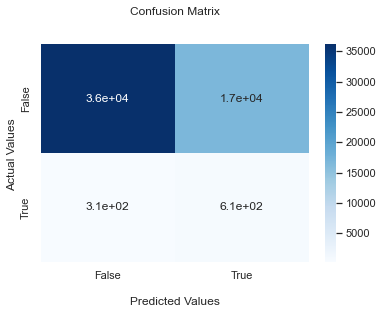

In [31]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, RFmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

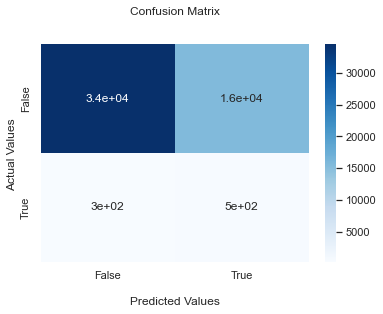

In [32]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, RFmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

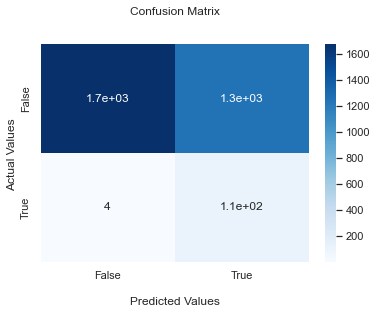

In [33]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, RFmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [34]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = RFmodel.predict_proba(X_res)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.503, AUROC-Score=0.73045


In [35]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (RFmodel.predict_proba(X_test)[:,1] >= 0.503).astype(int)
y_pred_UK = (RFmodel.predict_proba(X_test_UK)[:,1] >= 0.503).astype(int)
y_pred_Spain = (RFmodel.predict_proba(X_test_Spain)[:,1] >= 0.503).astype(int)

In [36]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6738437167734705
Accuracy is: 0.6874245939675174
Average Precision is: 0.029183623819985124
Weighted F1 is: 0.7995324802118667
Sensitivity is: 0.6597826086956522
#################################################
Results for UK
AUROC is: 0.6554000318827667
Accuracy is: 0.6934078256250861
Average Precision is: 0.025455468043245097
Weighted F1 is: 0.8048509083400137
Sensitivity is: 0.6161490683229813
#################################################
Results for Spain
AUROC is: 0.7689086614875
Accuracy is: 0.5874424720578567
Average Precision is: 0.07997801575365554
Weighted F1 is: 0.705764772281741
Sensitivity is: 0.9652173913043478


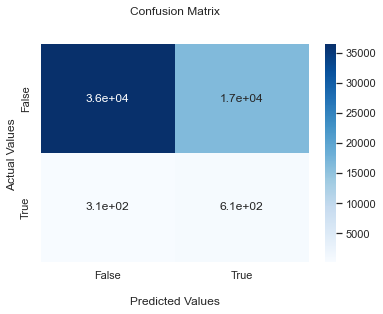

In [37]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

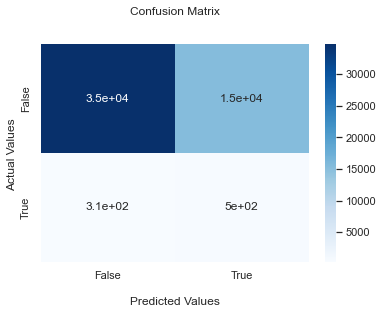

In [38]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

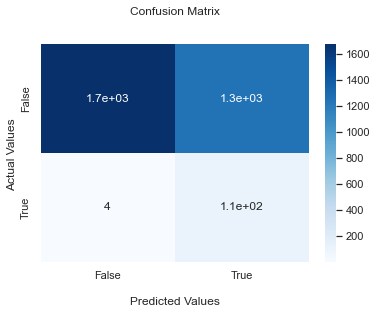

In [39]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# EasyEnsemble

In [51]:
# In this case we are tuning for EasyEnsemble hyperparameters
# maximum features
n_estimators = list(range(50, 400, 50))

# Create the grid
param_grid = {'n_estimators': n_estimators}

In [52]:
# Define the model you are interested in
EEModel = EasyEnsembleClassifier(random_state=42)

In [53]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(EEModel, param_grid, cv=cv, n_iter=10, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=EasyEnsembleClassifier(random_state=42), n_iter=10,
              refit=False, scoring='roc_auc',
              search_spaces={'n_estimators': [50, 100, 150, 200, 250, 300,
                                              350]},
              verbose=1)

In [54]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('n_estimators', 250)])
Best AUROC: 0.7295198554397835


Best parameter combo: OrderedDict([('n_estimators', 250)])

In [55]:
# Test the model on standalone set
EEModel = EasyEnsembleClassifier(n_estimators=250, random_state=42)

In [56]:
EEModel.fit(X_train, np.ravel(y_train))

EasyEnsembleClassifier(n_estimators=250, random_state=42)

In [57]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, EEModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, EEModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, EEModel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, EEModel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, EEModel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, EEModel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, EEModel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, EEModel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, EEModel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, EEModel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, EEModel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, EEModel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, EEModel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7176429741412931
Accuracy is: 0.6366403712296984
Average Precision is: 0.041231677065673794
Weighted F1 is: 0.7624934195158064
Sensitivity is: 0.7076086956521739
#################################################
Results for UK
AUROC is: 0.7027221898593932
Accuracy is: 0.6469222749001633
Average Precision is: 0.03374196952417312
Weighted F1 is: 0.7713174809268851
Sensitivity is: 0.6695652173913044
#################################################
Results for Spain
AUROC is: 0.7442655337858916
Accuracy is: 0.4648257725180802
Average Precision is: 0.07864297476639669
Weighted F1 is: 0.5966230261897166
Sensitivity is: 0.9739130434782609


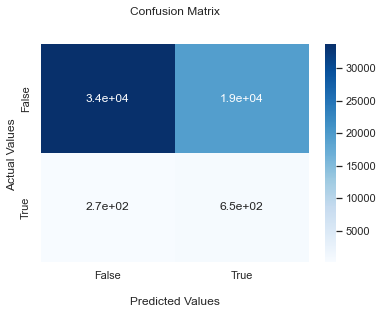

In [58]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, EEModel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

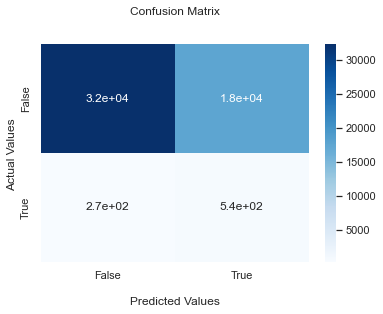

In [59]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, EEModel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

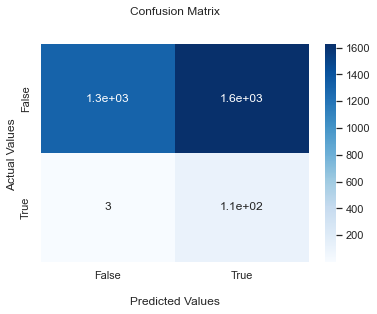

In [60]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, EEModel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = EEModel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.500, AUROC-Score=0.68136


In [62]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (EEModel.predict_proba(X_test)[:,1] >= 0.5).astype(int)
y_pred_UK = (EEModel.predict_proba(X_test_UK)[:,1] >= 0.5).astype(int)
y_pred_Spain = (EEModel.predict_proba(X_test_Spain)[:,1] >= 0.5).astype(int)

In [63]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6715080585238492
Accuracy is: 0.6366403712296984
Average Precision is: 0.028074172866823413
Weighted F1 is: 0.7624934195158064
Sensitivity is: 0.7076086956521739
#################################################
Results for UK
AUROC is: 0.6580615724759352
Accuracy is: 0.6469222749001633
Average Precision is: 0.025039398893460817
Weighted F1 is: 0.7713174809268851
Sensitivity is: 0.6695652173913044
#################################################
Results for Spain
AUROC is: 0.7093685477042826
Accuracy is: 0.4648257725180802
Average Precision is: 0.06378311952852303
Weighted F1 is: 0.5966230261897166
Sensitivity is: 0.9739130434782609


In [64]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [65]:
# Define the model you are interested in
EEModel = EasyEnsembleClassifier(random_state=42)

In [66]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', EEModel)]
model = Pipeline([
        ('sampling', under),
        ('classification', EEModel)
    ])

In [67]:
# In this case we are tuning for EasyEnsemble hyperparameters
# maximum features
n_estimators = list(range(50, 400, 50))

# Create the grid
param_grid = {'classification__n_estimators': n_estimators}

In [68]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, cv=cv, n_iter=10, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         EasyEnsembleClassifier(random_state=42))]),
              n_iter=10, refit=False, scoring='roc_auc',
              search_spaces={'classification__n_estimators': [50, 100, 150, 200,
                                                              250, 300, 350]},
              verbose=1)

In [69]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__n_estimators', 350)])
Best AUROC: 0.7284684322876972


# EasyEnsemble with XGBoost

In [98]:
# In this case we are tuning for EasyEnsemble hyperparameters
# maximum number of trees
n_estimators = list(range(10, 100, 10))

# Create the grid
param_grid = {'n_estimators': n_estimators}

In [100]:
# Define the model you are interested in
EEModel = EasyEnsembleClassifier(random_state=42, base_estimator=XGBClassifier(use_label_encoder=False))

In [101]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(EEModel, param_grid, cv=cv, n_iter=10, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[21:28:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:49] WARNING: /Users/runner/miniforge3/cond

[21:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:00] WARNING: /Users/runner/miniforge3/cond

[21:29:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:11] WARNING: /Users/runner/miniforge3/cond

[21:29:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:24] WARNING: /Users/runner/miniforge3/cond

[21:29:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:36] WARNING: /Users/runner/miniforge3/cond

[21:29:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:48] WARNING: /Users/runner/miniforge3/cond

[21:30:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:02] WARNING: /Users/runner/miniforge3/cond

[21:30:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:15] WARNING: /Users/runner/miniforge3/cond

[21:30:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:27] WARNING: /Users/runner/miniforge3/cond

[21:30:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:40] WARNING: /Users/runner/miniforge3/cond

[21:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:53] WARNING: /Users/runner/miniforge3/cond

[21:31:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:04] WARNING: /Users/runner/miniforge3/cond

[21:31:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:16] WARNING: /Users/runner/miniforge3/cond

[21:31:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:30] WARNING: /Users/runner/miniforge3/cond

[21:31:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:42] WARNING: /Users/runner/miniforge3/cond

[21:31:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:31:54] WARNING: /Users/runner/miniforge3/cond

[21:32:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:09] WARNING: /Users/runner/miniforge3/cond

[21:32:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:20] WARNING: /Users/runner/miniforge3/cond

[21:32:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:31] WARNING: /Users/runner/miniforge3/cond

[21:32:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:44] WARNING: /Users/runner/miniforge3/cond

[21:32:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:56] WARNING: /Users/runner/miniforge3/cond

[21:33:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:07] WARNING: /Users/runner/miniforge3/cond

[21:33:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[21:33:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[21:33:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:32] WARNING: /Users/runner/miniforge3/cond

[21:33:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:46] WARNING: /Users/runner/miniforge3/cond

[21:33:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:57] WARNING: /Users/runner/miniforge3/cond

[21:34:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:11] WARNING: /Users/runner/miniforge3/cond

[21:34:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:22] WARNING: /Users/runner/miniforge3/cond

[21:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:34] WARNING: /Users/runner/miniforge3/cond

[21:34:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:45] WARNING: /Users/runner/miniforge3/cond

[21:34:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:34:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:00] WARNING: /Users/runner/miniforge3/cond

[21:35:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:12] WARNING: /Users/runner/miniforge3/cond

[21:35:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:28] WARNING: /Users/runner/miniforge3/cond

[21:35:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:43] WARNING: /Users/runner/miniforge3/cond

[21:35:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:54] WARNING: /Users/runner/miniforge3/cond

[21:36:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:07] WARNING: /Users/runner/miniforge3/cond

[21:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:19] WARNING: /Users/runner/miniforge3/cond

[21:36:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:32] WARNING: /Users/runner/miniforge3/cond

[21:36:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:45] WARNING: /Users/runner/miniforge3/cond

[21:36:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:56] WARNING: /Users/runner/miniforge3/cond

[21:37:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:10] WARNING: /Users/runner/miniforge3/cond

[21:37:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:22] WARNING: /Users/runner/miniforge3/cond

[21:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:33] WARNING: /Users/runner/miniforge3/cond

[21:37:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:46] WARNING: /Users/runner/miniforge3/cond

[21:37:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:59] WARNING: /Users/runner/miniforge3/cond

[21:38:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:10] WARNING: /Users/runner/miniforge3/cond

[21:38:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:23] WARNING: /Users/runner/miniforge3/cond

[21:38:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:35] WARNING: /Users/runner/miniforge3/cond

[21:38:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:48] WARNING: /Users/runner/miniforge3/cond

[21:38:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:59] WARNING: /Users/runner/miniforge3/cond

[21:39:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:11] WARNING: /Users/runner/miniforge3/cond

[21:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:24] WARNING: /Users/runner/miniforge3/cond

[21:39:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:35] WARNING: /Users/runner/miniforge3/cond

[21:39:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:48] WARNING: /Users/runner/miniforge3/cond

[21:40:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:01] WARNING: /Users/runner/miniforge3/cond

[21:40:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:14] WARNING: /Users/runner/miniforge3/cond

[21:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:28] WARNING: /Users/runner/miniforge3/cond

[21:40:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:40] WARNING: /Users/runner/miniforge3/cond

[21:40:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:51] WARNING: /Users/runner/miniforge3/cond

[21:41:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:05] WARNING: /Users/runner/miniforge3/cond

[21:41:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:16] WARNING: /Users/runner/miniforge3/cond

[21:41:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:28] WARNING: /Users/runner/miniforge3/cond

[21:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:42] WARNING: /Users/runner/miniforge3/cond

[21:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:53] WARNING: /Users/runner/miniforge3/cond

[21:42:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:08] WARNING: /Users/runner/miniforge3/cond

[21:42:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:20] WARNING: /Users/runner/miniforge3/cond

[21:42:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:32] WARNING: /Users/runner/miniforge3/cond

[21:42:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:47] WARNING: /Users/runner/miniforge3/cond

[21:42:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:58] WARNING: /Users/runner/miniforge3/cond

[21:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:11] WARNING: /Users/runner/miniforge3/cond

[21:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:25] WARNING: /Users/runner/miniforge3/cond

[21:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:39] WARNING: /Users/runner/miniforge3/cond

[21:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[21:43:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[21:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:04] WARNING: /Users/runner/miniforge3/cond

[21:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:16] WARNING: /Users/runner/miniforge3/cond

[21:44:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:30] WARNING: /Users/runner/miniforge3/cond

[21:44:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:42] WARNING: /Users/runner/miniforge3/cond

[21:44:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:56] WARNING: /Users/runner/miniforge3/cond

[21:45:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:08] WARNING: /Users/runner/miniforge3/cond

[21:45:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:22] WARNING: /Users/runner/miniforge3/cond

[21:45:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:35] WARNING: /Users/runner/miniforge3/cond

[21:45:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:47] WARNING: /Users/runner/miniforge3/cond

[21:46:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:02] WARNING: /Users/runner/miniforge3/cond

[21:46:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:15] WARNING: /Users/runner/miniforge3/cond

[21:46:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:28] WARNING: /Users/runner/miniforge3/cond

[21:46:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:40] WARNING: /Users/runner/miniforge3/cond

[21:46:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:46:54] WARNING: /Users/runner/miniforge3/cond

[21:47:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:05] WARNING: /Users/runner/miniforge3/cond

[21:47:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:17] WARNING: /Users/runner/miniforge3/cond

[21:47:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:28] WARNING: /Users/runner/miniforge3/cond

[21:47:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:40] WARNING: /Users/runner/miniforge3/cond

[21:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:52] WARNING: /Users/runner/miniforge3/cond

[21:48:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:04] WARNING: /Users/runner/miniforge3/cond

[21:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:15] WARNING: /Users/runner/miniforge3/cond

[21:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:27] WARNING: /Users/runner/miniforge3/cond

[21:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:40] WARNING: /Users/runner/miniforge3/cond

[21:48:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:54] WARNING: /Users/runner/miniforge3/cond

[21:49:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:09] WARNING: /Users/runner/miniforge3/cond

[21:49:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:20] WARNING: /Users/runner/miniforge3/cond

[21:49:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:31] WARNING: /Users/runner/miniforge3/cond

[21:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:42] WARNING: /Users/runner/miniforge3/cond

[21:49:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:55] WARNING: /Users/runner/miniforge3/cond

[21:50:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:08] WARNING: /Users/runner/miniforge3/cond

[21:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:19] WARNING: /Users/runner/miniforge3/cond

[21:50:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:35] WARNING: /Users/runner/miniforge3/cond

[21:50:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:47] WARNING: /Users/runner/miniforge3/cond

[21:50:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:58] WARNING: /Users/runner/miniforge3/cond

[21:51:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:12] WARNING: /Users/runner/miniforge3/cond

[21:51:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:23] WARNING: /Users/runner/miniforge3/cond

[21:51:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:34] WARNING: /Users/runner/miniforge3/cond

[21:51:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:46] WARNING: /Users/runner/miniforge3/cond

[21:52:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:02] WARNING: /Users/runner/miniforge3/cond

[21:52:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:19] WARNING: /Users/runner/miniforge3/cond

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=EasyEnsembleClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            enable_categorical=False,
                                                                            gamma=None,
                                                                            gpu_id=None,
                                                                            importance_type=None,
                                                                 

In [102]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score 
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('n_estimators', 80)])
Best AUROC: 0.7358785249782397


In [103]:
# Test the model on standalone set
EEModel = EasyEnsembleClassifier(n_estimators=80, random_state=42, base_estimator=XGBClassifier(use_label_encoder=False))

In [104]:
EEModel.fit(X_train, np.ravel(y_train))

[22:13:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:48] WARNING: /Users/runner/miniforge3/cond

[22:13:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:59] WARNING: /Users/runner/miniforge3/cond

[22:14:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:11] WARNING: /Users/runner/miniforge3/cond

[22:14:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


EasyEnsembleClassifier(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    enable_categorical=False,
                                                    gamma=None, gpu_id=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                        

In [105]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, EEModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, EEModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, EEModel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, EEModel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, EEModel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, EEModel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, EEModel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, EEModel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, EEModel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, EEModel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, EEModel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, EEModel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, EEModel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7382628605912321
Accuracy is: 0.6447146171693735
Average Precision is: 0.049851563886396215
Weighted F1 is: 0.768540588639752
Sensitivity is: 0.7
#################################################
Results for UK
AUROC is: 0.7162698826545333
Accuracy is: 0.6487124505734464
Average Precision is: 0.036849432177917564
Weighted F1 is: 0.7726643228662546
Sensitivity is: 0.6608695652173913
#################################################
Results for Spain
AUROC is: 0.8077791476656615
Accuracy is: 0.5779092702169625
Average Precision is: 0.11082754921298804
Weighted F1 is: 0.6978245900532167
Sensitivity is: 0.9739130434782609


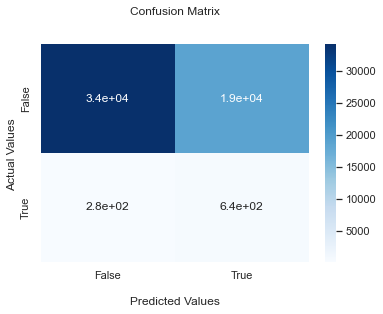

In [106]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, EEModel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

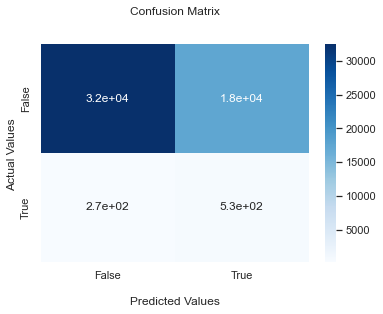

In [107]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, EEModel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

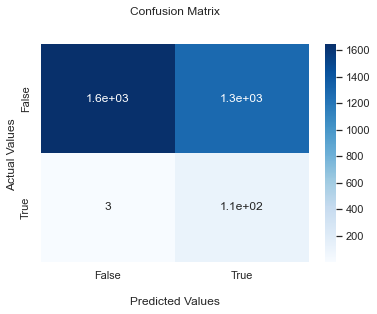

In [108]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, EEModel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# LDA

In [26]:
# In this case we are tuning for LDA hyperparameters
# Regularisation
shrinkage = list(np.arange(0, 1, 0.01))
# Solvers
solver = ['lsqr', 'eigen']
# Create the grid
param_grid = {'shrinkage': shrinkage,
             'solver': solver}

In [27]:
LDAModel = LinearDiscriminantAnalysis()

In [28]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LDAModel, param_grid, cv=cv, n_iter=50, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LinearDiscriminantAnalysis(), refit=False,
              scoring='roc_auc',
              search_spaces={'shrinkage': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                           0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                                           0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
                                           0.18, 0.19, 0.2, 0.21, 0.22, 0.23,
                                           0.24, 0.25, 0.26, 0.27, 0.28, 0.29, ...],
                             'solver': ['lsqr', 'eigen']},
              verbose=1)

In [29]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('shrinkage', 0.17), ('solver', 'eigen')])
Best AUROC: 0.7215701877861675


In [30]:
# Test the model on standalone set
LDAModel = LinearDiscriminantAnalysis(shrinkage=0.17, solver = 'eigen')

In [31]:
LDAModel.fit(X_train, np.ravel(y_train))

LinearDiscriminantAnalysis(shrinkage=0.17, solver='eigen')

In [32]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LDAModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LDAModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LDAModel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, LDAModel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, LDAModel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, LDAModel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, LDAModel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, LDAModel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, LDAModel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, LDAModel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, LDAModel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, LDAModel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, LDAModel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7058887160140069
Accuracy is: 0.9829234338747099
Average Precision is: 0.041423524365780034
Weighted F1 is: 0.9744586809105171
Sensitivity is: 0.0
#################################################
Results for UK
AUROC is: 0.6916496078965966
Accuracy is: 0.9841638305824956
Average Precision is: 0.0329916949939723
Weighted F1 is: 0.976308942334125
Sensitivity is: 0.0
#################################################
Results for Spain
AUROC is: 0.7360392745205805
Accuracy is: 0.9621959237343852
Average Precision is: 0.08448471392037865
Weighted F1 is: 0.9436580562139539
Sensitivity is: 0.0


In [33]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LDAModel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.018, AUROC-Score=0.67187


In [34]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (LDAModel.predict_proba(X_test)[:,1] >= 0.018).astype(int)
y_pred_UK = (LDAModel.predict_proba(X_test_UK)[:,1] >= 0.018).astype(int)
y_pred_Spain = (LDAModel.predict_proba(X_test_Spain)[:,1] >= 0.018).astype(int)

In [35]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6649369029487712
Accuracy is: 0.6667656612529003
Average Precision is: 0.027912419046084432
Weighted F1 is: 0.7847887430772852
Sensitivity is: 0.6630434782608695
#################################################
Results for UK
AUROC is: 0.6531842044231628
Accuracy is: 0.6866405681348731
Average Precision is: 0.025151015571114342
Weighted F1 is: 0.8000997597031132
Sensitivity is: 0.6186335403726708
#################################################
Results for Spain
AUROC is: 0.641722493724098
Accuracy is: 0.3346482577251808
Average Precision is: 0.052124618455425785
Weighted F1 is: 0.4582766032819084
Sensitivity is: 0.9739130434782609


In [36]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [37]:
# Define the model you are interested in
LDAModel = LinearDiscriminantAnalysis()

In [38]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', LDAModel)]
model = Pipeline([
        ('sampling', under),
        ('classification', LDAModel)
    ])

In [43]:
# In this case we are tuning for LDA hyperparameters
# Regularisation
shrinkage = list(np.arange(0, 1, 0.01))
# Solvers
solver = ['lsqr', 'eigen']
# Create the grid
param_grid = {'classification__shrinkage': shrinkage,
             'classification__solver': solver}

In [46]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, cv=cv, n_iter=50, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         LinearDiscriminantAnalysis())]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__shrinkage': [0.0, 0.01, 0.02,
                                                           0.03, 0.04, 0.05,
                                                           0.06, 0.07, 0.08,
                                                           0.09, 0.1, 0.11,
                                                           0.12, 0.13, 0.14,
                                                           0.15, 0.16, 0.17,
                                                           0.18, 0.1

In [47]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__shrinkage', 0.1), ('classification__solver', 'eigen')])
Best AUROC: 0.7219030883092865


In [48]:
LDAModel = LinearDiscriminantAnalysis(shrinkage = 0.1, solver = 'eigen')

In [49]:
LDAModel.fit(X_res, np.ravel(y_res))

LinearDiscriminantAnalysis(shrinkage=0.1, solver='eigen')

In [50]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LDAModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LDAModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LDAModel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, LDAModel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, LDAModel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, LDAModel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, LDAModel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, LDAModel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, LDAModel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, LDAModel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, LDAModel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, LDAModel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, LDAModel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.7062913343158465
Accuracy is: 0.9594060324825986
Average Precision is: 0.040864797883914804
Weighted F1 is: 0.9638235470104726
Sensitivity is: 0.09782608695652174
#################################################
Results for UK
AUROC is: 0.6915908581877379
Accuracy is: 0.969724391635355
Average Precision is: 0.03292441851728246
Weighted F1 is: 0.9697888641278715
Sensitivity is: 0.0484472049689441
#################################################
Results for Spain
AUROC is: 0.738790273465932
Accuracy is: 0.7869822485207101
Average Precision is: 0.08364556257747757
Weighted F1 is: 0.8504450848969322
Sensitivity is: 0.4434782608695652


In [52]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LDAModel.predict_proba(X_res)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.193, AUROC-Score=0.67973


In [53]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (LDAModel.predict_proba(X_test)[:,1] >= 0.193).astype(int)
y_pred_UK = (LDAModel.predict_proba(X_test_UK)[:,1] >= 0.193).astype(int)
y_pred_Spain = (LDAModel.predict_proba(X_test_Spain)[:,1] >= 0.193).astype(int)

In [54]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6671908162385618
Accuracy is: 0.632352668213457
Average Precision is: 0.027613729196749443
Weighted F1 is: 0.7592852479423151
Sensitivity is: 0.7032608695652174
#################################################
Results for UK
AUROC is: 0.6552787333503175
Accuracy is: 0.6450534101862962
Average Precision is: 0.024783342129663516
Weighted F1 is: 0.7699453114292149
Sensitivity is: 0.6658385093167701
#################################################
Results for Spain
AUROC is: 0.681959566851354
Accuracy is: 0.42011834319526625
Average Precision is: 0.05857795508921926
Weighted F1 is: 0.5522407883976594
Sensitivity is: 0.9652173913043478


# Naive Bayes

In [12]:
# In this case we are tuning for Naive Bayes hyperparameters
# Smoothing parameter
alpha = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]

# Create the grid
param_grid = {'alpha': alpha}

In [13]:
# Define the model you are interested in
NBmodel = CategoricalNB()

In [14]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(NBmodel, param_grid, cv=cv, n_iter=20, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=CategoricalNB(), n_iter=20, refit=False,
              scoring='roc_auc',
              search_spaces={'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05,
                                       0]},
              verbose=1)

In [15]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('alpha', 0.0)])
Best AUROC: 0.7043125341530149


Best parameter combo: OrderedDict([('alpha', 0.0)])

In [16]:
# Test the model on standalone set
NBmodel = CategoricalNB(alpha=0.0)

In [17]:
NBmodel.fit(X_train, np.ravel(y_train))

alpha too small will result in numeric errors, setting alpha = 1.0e-10


CategoricalNB(alpha=0.0)

In [18]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, NBmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, NBmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, NBmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, NBmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, NBmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, NBmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, NBmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, NBmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, NBmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, NBmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, NBmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, NBmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, NBmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.6911753827080417
Accuracy is: 0.9811786542923434
Average Precision is: 0.03278380803517047
Weighted F1 is: 0.9738494546511801
Sensitivity is: 0.008695652173913044
#################################################
Results for UK
AUROC is: 0.6719859859844947
Accuracy is: 0.9826490665512561
Average Precision is: 0.027232228628469544
Weighted F1 is: 0.9756926938255621
Sensitivity is: 0.004968944099378882
#################################################
Results for Spain
AUROC is: 0.7761753390472512
Accuracy is: 0.9566074950690335
Average Precision is: 0.09050283756756133
Weighted F1 is: 0.9429884140775537
Sensitivity is: 0.034782608695652174


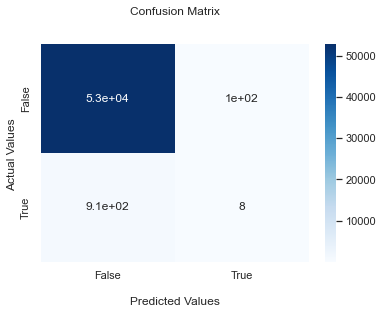

In [19]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, NBmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

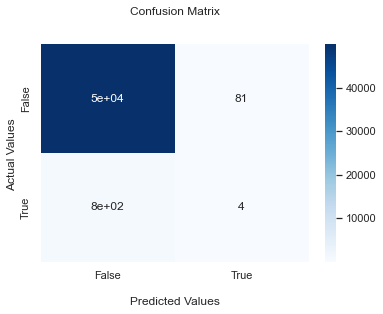

In [20]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, NBmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

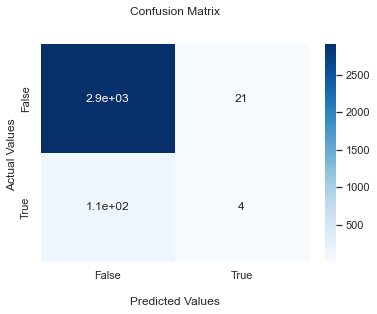

In [21]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, NBmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [22]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = NBmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.017, AUROC-Score=0.66706


In [23]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (NBmodel.predict_proba(X_test)[:,1] >= 0.017).astype(int)
y_pred_UK = (NBmodel.predict_proba(X_test_UK)[:,1] >= 0.017).astype(int)
y_pred_Spain = (NBmodel.predict_proba(X_test_Spain)[:,1] >= 0.017).astype(int)

In [24]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6531007664423855
Accuracy is: 0.6183016241299304
Average Precision is: 0.026201311142980657
Weighted F1 is: 0.748657929605487
Sensitivity is: 0.6891304347826087
#################################################
Results for UK
AUROC is: 0.6364660758919105
Accuracy is: 0.6188499596718667
Average Precision is: 0.023049655184832072
Weighted F1 is: 0.750258094406584
Sensitivity is: 0.6546583850931676
#################################################
Results for Spain
AUROC is: 0.7634749929442521
Accuracy is: 0.60913872452334
Average Precision is: 0.07992528491656017
Weighted F1 is: 0.7235590815152203
Sensitivity is: 0.9304347826086956


In [25]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [26]:
# Define the model you are interested in
NBmodel = CategoricalNB()

In [27]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', NBmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', NBmodel)
    ])

In [28]:
# In this case we are tuning for Naive Bayes hyperparameters
# Smoothing parameter
alpha = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]

# Create the grid
param_grid = {'classification__alpha': alpha}

In [29]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=20, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10


Fitting 5 folds for each of 1 candidates, totalling 5 fits


alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification', CategoricalNB())]),
              n_iter=20, refit=False, scoring='roc_auc',
              search_spaces={'classification__alpha': [1.0, 0.1, 0.01, 0.001,
                                                       0.0001, 1e-05, 0]},
              verbose=1)

In [30]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__alpha', 1e-05)])
Best AUROC: 0.7039152805598294


In [31]:
# Test the model on standalone set
NBmodel = CategoricalNB(alpha=1e-05)

In [32]:
NBmodel.fit(X_res, np.ravel(y_res))

CategoricalNB(alpha=1e-05)

In [34]:
# Test results with undersampling and without thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, NBmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, NBmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, NBmodel.predict(X_test)))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, NBmodel.predict_proba(X_test_UK)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, NBmodel.predict(X_test_UK)))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, NBmodel.predict_proba(X_test_UK)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, NBmodel.predict(X_test_UK), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, NBmodel.predict(X_test_UK)))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, NBmodel.predict_proba(X_test_Spain)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, NBmodel.predict(X_test_Spain)))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, NBmodel.predict_proba(X_test_Spain)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, NBmodel.predict(X_test_Spain), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, NBmodel.predict(X_test_Spain)))

Results for UK+Spain
AUROC is: 0.6904520450095036
Accuracy is: 0.8269512761020882
Average Precision is: 0.03247415650904767
Weighted F1 is: 0.8903021263304288
Sensitivity is: 0.3423913043478261
#################################################
Results for UK
AUROC is: 0.6716148894507274
Accuracy is: 0.8334743178643794
Average Precision is: 0.02720874993058886
Weighted F1 is: 0.895162583664689
Sensitivity is: 0.2968944099378882
#################################################
Results for Spain
AUROC is: 0.7761456306353144
Accuracy is: 0.717948717948718
Average Precision is: 0.09107621474181235
Weighted F1 is: 0.8051804604371174
Sensitivity is: 0.6608695652173913


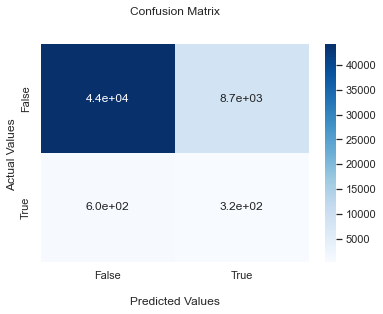

In [35]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, NBmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

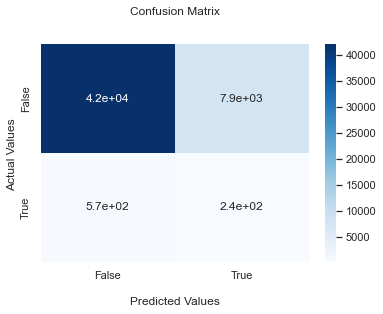

In [36]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, NBmodel.predict(X_test_UK)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

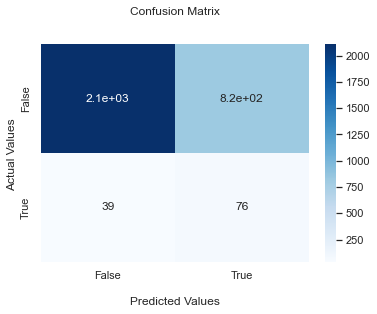

In [37]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, NBmodel.predict(X_test_Spain)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [38]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = NBmodel.predict_proba(X_res)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.197, AUROC-Score=0.66879


In [39]:
# Set the optimal threshold for class imbalance purposes
y_pred_UKSpain = (NBmodel.predict_proba(X_test)[:,1] >= 0.197).astype(int)
y_pred_UK = (NBmodel.predict_proba(X_test_UK)[:,1] >= 0.197).astype(int)
y_pred_Spain = (NBmodel.predict_proba(X_test_Spain)[:,1] >= 0.197).astype(int)

In [40]:
# Test results with thresholding and undersampling
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred_UKSpain))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred_UKSpain))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred_UKSpain))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred_UKSpain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred_UKSpain))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, y_pred_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, y_pred_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, y_pred_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, y_pred_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, y_pred_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, y_pred_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, y_pred_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, y_pred_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, y_pred_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, y_pred_Spain))

Results for UK+Spain
AUROC is: 0.6515617238590601
Accuracy is: 0.6152761020881671
Average Precision is: 0.026039720898028744
Weighted F1 is: 0.7463351056988757
Sensitivity is: 0.6891304347826087
#################################################
Results for UK
AUROC is: 0.6347870161653573
Accuracy is: 0.615545019967344
Average Precision is: 0.02290042474661489
Weighted F1 is: 0.7477255207813158
Sensitivity is: 0.6546583850931676
#################################################
Results for Spain
AUROC is: 0.7643291097874363
Accuracy is: 0.6107823800131492
Average Precision is: 0.08022651420780283
Weighted F1 is: 0.724867155739614
Sensitivity is: 0.9304347826086956


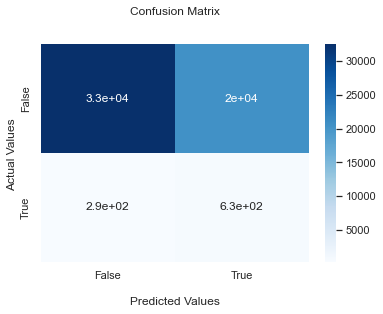

In [41]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_UKSpain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

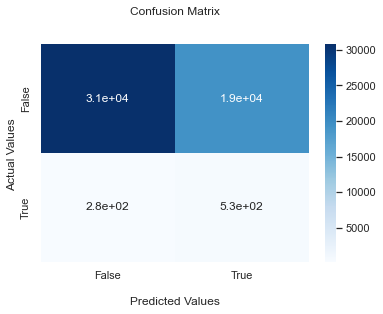

In [42]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_UK, y_pred_UK), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

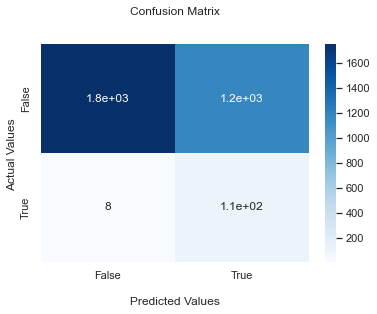

In [43]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test_Spain, y_pred_Spain), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# SuperLearner

In [42]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight = 'balanced'))
    models.append(XGBClassifier(max_depth = 3, n_estimators = 150,learning_rate = 0.1, max_delta_step = 0, scale_pos_weight = 57.527, min_split_loss = 0.5, use_label_encoder=False))
    models.append(LinearDiscriminantAnalysis(shrinkage=0.17, solver = 'eigen'))
    models.append(RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', max_depth = 10, min_samples_split = 5, min_samples_leaf = 10, bootstrap = False, class_weight = 'balanced_subsample'))
    return models

# create the super learner
def get_super_learner():
    ensemble = SuperLearner(scorer=metrics.roc_auc_score, folds=5, shuffle=True)
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight = 'balanced'))
    return ensemble

In [43]:
# create the super learner
ensemble = get_super_learner()
# fit the super learner
ensemble.fit(X_train, y_train)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_test)
yhat_UK = ensemble.predict(X_test_UK)
yhat_Spain = ensemble.predict(X_test_Spain)

[11:12:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:10] WARNING: /Users/runner/miniforge3/cond

                                       score-m  score-s   ft-m  ft-s  pt-m  pt-s
layer-1  lineardiscriminantanalysis       0.50     0.00   0.90  0.09  0.02  0.01
layer-1  logisticregression               0.67     0.01   4.60  0.23  0.02  0.01
layer-1  randomforestclassifier           0.67     0.02  43.95  0.77  0.65  0.08
layer-1  xgbclassifier                    0.68     0.01  22.45  4.26  0.04  0.02



In [44]:
# Test results without undersampling or thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, yhat))
print('Accuracy is:', metrics.accuracy_score(y_test, yhat))
print('Average Precision is:', metrics.average_precision_score(y_test, yhat))
print('Weighted F1 is:', metrics.f1_score(y_test, yhat, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, yhat))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, yhat_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, yhat_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, yhat_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, yhat_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, yhat_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, yhat_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, yhat_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, yhat_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, yhat_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, yhat_Spain))

Results for UK+Spain
AUROC is: 0.6730527970836601
Accuracy is: 0.6554245939675174
Average Precision is: 0.028514724839024015
Weighted F1 is: 0.7764634788276076
Sensitivity is: 0.691304347826087
#################################################
Results for UK
AUROC is: 0.6566118625743497
Accuracy is: 0.6609092518639467
Average Precision is: 0.025093595176291866
Weighted F1 is: 0.7816162201917796
Sensitivity is: 0.6521739130434783
#################################################
Results for Spain
AUROC is: 0.7566093789456485
Accuracy is: 0.5637738330046023
Average Precision is: 0.07602840447189112
Weighted F1 is: 0.686062893158719
Sensitivity is: 0.9652173913043478


In [36]:
# With undersampling
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [37]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LogisticRegression(C=1.0, penalty='l1', solver='liblinear', class_weight = 'balanced'))
    models.append(XGBClassifier(max_depth = 2, n_estimators = 200,learning_rate = 0.3, max_delta_step = 0, min_split_loss = 0.06220097640444155, scale_pos_weight = 4, use_label_encoder=False))
    models.append(LinearDiscriminantAnalysis(shrinkage = 0.1, solver = 'eigen'))
    models.append(RandomForestClassifier(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_split = 10, min_samples_leaf = 10, bootstrap = True, class_weight = 'balanced_subsample'))
    return models

# create the super learner
def get_super_learner():
    ensemble = SuperLearner(scorer=metrics.roc_auc_score, folds=5, shuffle=True)
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(LogisticRegression(solver='liblinear', class_weight = 'balanced'))
    return ensemble

In [38]:
# create the super learner
ensemble = get_super_learner()
# fit the super learner
ensemble.fit(X_res, y_res)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_test)
yhat_UK = ensemble.predict(X_test_UK)
yhat_Spain = ensemble.predict(X_test_Spain)

[10:56:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:15] WARNING: /Users/runner/miniforge3/cond

                                       score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  lineardiscriminantanalysis       0.54     0.00  0.07  0.01  0.00  0.00
layer-1  logisticregression               0.67     0.00  0.13  0.03  0.01  0.01
layer-1  randomforestclassifier           0.68     0.01  3.53  0.09  0.19  0.04
layer-1  xgbclassifier                    0.68     0.00  1.93  0.18  0.01  0.00



In [39]:
# Test results with undersampling and without thresholding
print('Results for UK+Spain')
print('AUROC is:', metrics.roc_auc_score(y_test, yhat))
print('Accuracy is:', metrics.accuracy_score(y_test, yhat))
print('Average Precision is:', metrics.average_precision_score(y_test, yhat))
print('Weighted F1 is:', metrics.f1_score(y_test, yhat, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, yhat))
print('#################################################')
print('Results for UK')
print('AUROC is:', metrics.roc_auc_score(y_test_UK, yhat_UK))
print('Accuracy is:', metrics.accuracy_score(y_test_UK, yhat_UK))
print('Average Precision is:', metrics.average_precision_score(y_test_UK, yhat_UK))
print('Weighted F1 is:', metrics.f1_score(y_test_UK, yhat_UK, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_UK, yhat_UK))
print('#################################################')
print('Results for Spain')
print('AUROC is:', metrics.roc_auc_score(y_test_Spain, yhat_Spain))
print('Accuracy is:', metrics.accuracy_score(y_test_Spain, yhat_Spain))
print('Average Precision is:', metrics.average_precision_score(y_test_Spain, yhat_Spain))
print('Weighted F1 is:', metrics.f1_score(y_test_Spain, yhat_Spain, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_Spain, yhat_Spain))

Results for UK+Spain
AUROC is: 0.6756973209410779
Accuracy is: 0.6679721577726218
Average Precision is: 0.02899650706897844
Weighted F1 is: 0.7856059499533783
Sensitivity is: 0.683695652173913
#################################################
Results for UK
AUROC is: 0.6594899899534521
Accuracy is: 0.6749945901284599
Average Precision is: 0.02554336817063419
Weighted F1 is: 0.791785198646678
Sensitivity is: 0.6434782608695652
#################################################
Results for Spain
AUROC is: 0.7497764442001753
Accuracy is: 0.5506245890861275
Average Precision is: 0.07400090162032956
Weighted F1 is: 0.6748586789218554
Sensitivity is: 0.9652173913043478
